## Fine-tuning BioMed-RoBERTa on HUMADEX dataset

### Setup


In [ ]:
# Check CUDA availbility and PyTorch installation

try:
    import torch

    print("✅ PyTorch is installed.")
    print("PyTorch version:", torch.__version__)
    print("Built with CUDA version:", torch.version.cuda)
    print("CUDA available:", torch.cuda.is_available())

    if torch.cuda.is_available():
        print("Detected GPU:", torch.cuda.get_device_name(0))
    else:
        print("❌ CUDA not available. PyTorch is running on CPU.")

except ImportError:
    print("❌ PyTorch is not installed in this environment.")


✅ PyTorch is installed.
PyTorch version: 2.5.1+cu121
Built with CUDA version: 12.1
CUDA available: True
Detected GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
# ''' Testing HuggingFace GPU '''

from transformers import pipeline
qa = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", device=0)
qa(question="What is CUDA?", context="CUDA is a parallel computing platform and API from Nvidia.")

Device set to use cuda:0


{'score': 0.29723653197288513,
 'start': 8,
 'end': 37,
 'answer': 'a parallel computing platform'}

Interpreting the output:

- 'score': 0.29723653197288513, <- the confidence score assigned to this prediction (ranges 0-1; higher means more confidence)
- 'start': 8, <- character positions in the context string where the answer is found
- 'end': 37,
- 'answer': 'a parallel computing platform' <- the text snippet selected fromt he context; the model's best guess to the question

In [ ]:
''' [Option] Mount drive if working in colab '''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
''' Import libraries and HUMADEX dataset '''

import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import seqeval
import evaluate
from seqeval.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForTokenClassification

import datasets
from datasets import load_dataset
from datasets import load_dataset
from huggingface_hub import login, notebook_login, HfApi

import dotenv
from dotenv import load_dotenv

load_dotenv()

login(token= os.getenv('HUGGINGFACE_TOKEN'))
api = HfApi()

control_ds = load_dataset("HUMADEX/english_ner_dataset", split='train')
control_ds

c:\Users\chery\projects\symptom_entity_normalization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 445284/445284 [00:00<00:00, 958063.40 examples/s]


Dataset({
    features: ['sentence', 'tags'],
    num_rows: 445284
})

In [ ]:
''' Set label encoding '''

from datasets import ClassLabel

label_map = {
    0: "O",
    1: "B-PROBLEM",
    2: "I-PROBLEM",
    3: "E-PROBLEM",
    4: "S-PROBLEM",
    5: "B-TREATMENT",
    6: "I-TREATMENT",
    7: "E-TREATMENT",
    8: "S-TREATMENT",
    9: "B-TEST",
    10: "I-TEST",
    11: "E-TEST",
    12: "S-TEST"
}

label2id = {v: k for k, v in label_map.items()}
id2label = {k: v for k, v in label_map.items()}

In [ ]:
from datasets import DatasetDict

# split 80:20 train to test
test_split = control_ds.train_test_split(test_size=0.2, seed=42)

# split the 20% of train to 10% test 10% val
val_test = test_split['test'].train_test_split(test_size=0.5, seed=42)

# Wrap up
ds_splits = DatasetDict({
    'train': test_split['train'],
    'validation': val_test['train'],
    'test': val_test['test']
})

ds_splits

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 356227
    })
    validation: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 44528
    })
    test: Dataset({
        features: ['sentence', 'tags'],
        num_rows: 44529
    })
})

## RoBERTa

In [ ]:
''' Init RoBERTa from HuggingFace Hub'''

tokenizer = AutoTokenizer.from_pretrained(
    "allenai/biomed_roberta_base",
    add_prefix_space=True   # RoBERTa requires this due to being Byte-level BPE
    )

tokenizer_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
''' Tokenize HUMADEX data sentences '''

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"],
        is_split_into_words=True,  # IMPORTANT for word-tokenized input
        truncation=True,           # cuts off long sequences
        padding="max_length",      # ensures consistent length
        max_length=128,            # adjust if needed
    )

    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                # Same word -> same label
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_ds = ds_splits.map(tokenize_and_align_labels, batched=True)

tokenized_ds['train'][0]

{'sentence': ['is',
  'having',
  'chronic',
  'diarrhea',
  'after',
  'appendix',
  'removed',
  'normal',
  'it',
  'has',
  'been',
  'removed',
  'over',
  '3',
  'weeks',
  'ago',
  'no',
  'chronic',
  'diarrhea',
  'is',
  'not',
  'related',
  'to',
  'appendix',
  'removal'],
 'tags': [0,
  0,
  1,
  3,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  3,
  0,
  0,
  0,
  0,
  5,
  7],
 'input_ids': [0,
  16,
  519,
  7642,
  28657,
  71,
  38836,
  2928,
  2340,
  24,
  34,
  57,
  2928,
  81,
  155,
  688,
  536,
  117,
  7642,
  28657,
  16,
  45,
  1330,
  7,
  38836,
  7129,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

### Train without CV

In [ ]:
# init RoBERTa trainer

model = AutoModelForTokenClassification.from_pretrained(
    "allenai/biomed_roberta_base",
    num_labels=len(label_map),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/cp2_roberta_output",
    run_name = "roberta_ner_humadex",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy = "epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True
)

from seqeval.metrics import accuracy_score, f1_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [id2label[label] for label in sent if label != -100]
        for sent in labels
    ]
    true_predictions = [
        [id2label[pred] for pred, label in zip(sent_preds, sent_labels) if label != -100]
        for sent_preds, sent_labels in zip(predictions, labels)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-15-3612342057.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_data = tokenized_ds["train"]
train_data[0]

{'sentence': ['is',
  'having',
  'chronic',
  'diarrhea',
  'after',
  'appendix',
  'removed',
  'normal',
  'it',
  'has',
  'been',
  'removed',
  'over',
  '3',
  'weeks',
  'ago',
  'no',
  'chronic',
  'diarrhea',
  'is',
  'not',
  'related',
  'to',
  'appendix',
  'removal'],
 'tags': [0,
  0,
  1,
  3,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  3,
  0,
  0,
  0,
  0,
  5,
  7],
 'input_ids': [0,
  16,
  519,
  7642,
  28657,
  71,
  38836,
  2928,
  2340,
  24,
  34,
  57,
  2928,
  81,
  155,
  688,
  536,
  117,
  7642,
  28657,
  16,
  45,
  1330,
  7,
  38836,
  7129,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
 

In [ ]:
#train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.313700,0.296137,0.891107,0.812824
2,0.264800,0.273691,0.900945,0.828100
3,0.223400,0.270810,0.904418,0.834415


TrainOutput(global_step=66795, training_loss=0.291261097213913, metrics={'train_runtime': 4159.6257, 'train_samples_per_second': 256.918, 'train_steps_per_second': 16.058, 'total_flos': 6.981766252028698e+16, 'train_loss': 0.291261097213913, 'epoch': 3.0})

In [ ]:
logs = trainer.state.log_history
bm_roberta_train_log = pd.DataFrame(logs)
bm_roberta_train_log.to_csv("/content/drive/MyDrive/bm_roberta_ner_training_log.csv", index=False)


# bm_roberta_train_log.to_csv("/data/bm_roberta_ner_training_log.csv", index=False) --- if using Colab

bm_roberta_train_log.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.7874,6.694943,0.000020,0.022457,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.5377,5.245325,0.000020,0.044914,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.4780,5.852498,0.000020,0.067370,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4587,7.412684,0.000019,0.089827,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4414,7.491414,0.000019,0.112284,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bm_roberta_summary = {
    "epoch": [1, 2, 3],
    "train_loss": [0.313700	, 0.264800, 0.223400],
    "val_loss": [0.296137, 0.273691, 0.270810],
    "accuracy": [0.891107, 0.900945, 0.904418],
    "f1": [0.812824, 0.828100, 0.834415]
}

bm_roberta_train_summary = pd.DataFrame(bm_roberta_summary)
bm_roberta_train_summary.to_csv("/data/bm_roberta_ner_training_summary.csv", index=False)

#bm_roberta_train_summary.to_csv("/content/drive/MyDrive/bm_roberta_ner_training_summary.csv", index=False) --- if using Colab

In [ ]:
bm_roberta_train_log = pd.read_csv("/data/bm_roberta_ner_training_log.csv")

#bm_roberta_train_log = pd.read_csv("/content/drive/MyDrive/bm_roberta_ner_training_log.csv") --- if using Colab
print(bm_roberta_train_log[["epoch", "step", "eval_loss", "eval_f1"]].dropna())

     epoch   step  eval_loss   eval_f1
44     1.0  22265   0.296137  0.812824
90     2.0  44530   0.273691  0.828100
135    3.0  66795   0.270810  0.834415


In [ ]:
# Filter rows that have eval loss
eval_df = bm_roberta_train_log[bm_roberta_train_log['eval_loss'].notnull()]
eval_df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
44,NaN,NaN,NaN,1.0,22265,0.296137,0.891107,0.812824,55.3998,803.757,50.235,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,2.0,44530,0.273691,0.900945,0.828100,55.4020,803.725,50.233,NaN,NaN,NaN,NaN,NaN
135,NaN,NaN,NaN,3.0,66795,0.270810,0.904418,0.834415,55.3311,804.755,50.297,NaN,NaN,NaN,NaN,NaN


#### Visualize - Train

In [ ]:
print(bm_roberta_train_log[["epoch", "step", "eval_loss"]].dropna())

     epoch   step  eval_loss
44     1.0  22265   0.296137
90     2.0  44530   0.273691
135    3.0  66795   0.270810


In [ ]:
logs = trainer.state.log_history
log_df = pd.DataFrame(logs)

# Split into train/eval logs
train_log_df = log_df[log_df['loss'].notna()]
eval_log_df = log_df[log_df['eval_loss'].notna()]

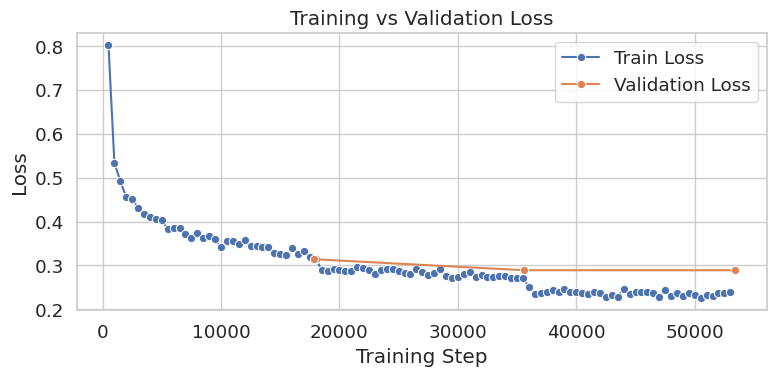

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8, 4))
sns.lineplot(data=train_log_df, x='step', y='loss', label='Train Loss', marker='o')
sns.lineplot(data=eval_log_df, x='step', y='eval_loss', label='Validation Loss', marker='o')

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


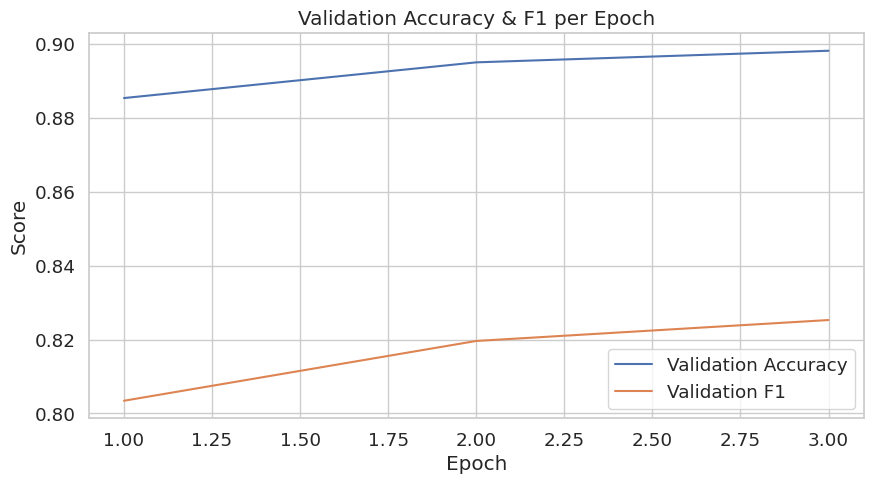

In [ ]:
eval_log_df = log_df[log_df['eval_loss'].notna()]

plt.figure(figsize=(10, 5))
plt.plot(eval_log_df['epoch'], eval_log_df['eval_accuracy'], label="Validation Accuracy")
plt.plot(eval_log_df['epoch'], eval_log_df['eval_f1'], label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy & F1 per Epoch")
plt.legend()
plt.show()

#### Cross-validation (K-Fold = 5 splits)

In [ ]:
# Combine all splits into one list for K-Fold CV
all_examples = []

for example in tokenized_ds['train']:
    all_examples.append({
        'input_ids': example['input_ids'],
        'attention_mask': example['attention_mask'],
        'labels': example['labels'],
    })

In [ ]:
#Dataset wrapper
class NERDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data[idx]['input_ids']),
            'attention_mask': torch.tensor(self.data[idx]['attention_mask']),
            'labels': torch.tensor(self.data[idx]['labels']),
        }

    def __len__(self):
        return len(self.data)

# compute metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [id2label[label] for label in sent if label != -100]
        for sent in labels
    ]
    true_predictions = [
        [id2label[pred] for pred, label in zip(sent_preds, sent_labels) if label != -100]
        for sent_preds, sent_labels in zip(predictions, labels)
    ]

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

#Tokenized dataset as a list
dataset = NERDataset(all_examples)

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, Subset
import os

resume_from = 5  # If session time out or crash, set # to the fold number you want to resume FROM and manually set last checkpoint path
checkpoint_path = "/data/cv_5/checkpoint-17812" #update cv_fold number 'cv_{fold number}'; for example this stops at fold 5, checkpoint 17812
#checkpoint_path = "/content/drive/MyDrive/cv_{fold_number}/checkpoint-17812" -- if using colab

kf = KFold(n_splits=5, shuffle=True, random_state=42) #K=5

fold_metrics = []

# ----- Training Loop -----
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    if fold < resume_from:
        print(f"\nSkipping Fold {fold+1} (already completed)")
        continue

    print(f"\nStarting Fold {fold+1}")

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    # If resuming from a specific checkpoint for this fold
    if fold == resume_from:
        print(f"Resuming from checkpoint: {checkpoint_path}")
        model = AutoModelForTokenClassification.from_pretrained(
            checkpoint_path,
            num_labels=len(label_map),
            id2label=id2label,
            label2id=label2id
        )
    else:
        model = AutoModelForTokenClassification.from_pretrained(
            "allenai/biomed_roberta_base",
            num_labels=len(label_map),
            id2label=id2label,
            label2id=label2id
        )

    # Update output_dir and run_name per fold
    training_args = TrainingArguments(
        #output_dir=f"/content/drive/MyDrive/cv_{fold}",
        output_dir=f"/data/cv_{fold}"
        run_name=f"roberta_ner_fold_{fold}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

     # Resume only for the specified fold
    if fold == resume_from:
        trainer.train(resume_from_checkpoint=checkpoint_path)
    else:
        trainer.train()

    eval_results = trainer.evaluate()
    print(f"Fold {fold+1} Evaluation: {eval_results}")

    fold_metrics.append({
        "fold": fold + 1,
        "eval_f1": eval_results.get("eval_f1"),
        "eval_accuracy": eval_results.get("eval_accuracy"),
    })

    #Clear GPU memory after each fold
    import gc
    import torch
    gc.collect()
    torch.cuda.empty_cache()



Skipping Fold 1 (already completed)

Skipping Fold 2 (already completed)

Starting Fold 3
Resuming from checkpoint: /content/drive/MyDrive/cp2_roberta_output/cv_2/checkpoint-17812


/tmp/ipython-input-31-1409482510.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
2,0.272900,0.286730,0.895992,0.821253
3,0.242200,0.285101,0.899557,0.827719


Fold 3 Evaluation: {'eval_loss': 0.28510093688964844, 'eval_accuracy': 0.8995570816581065, 'eval_f1': 0.8277191876402153, 'eval_runtime': 93.3438, 'eval_samples_per_second': 763.253, 'eval_steps_per_second': 47.705, 'epoch': 3.0}

Starting Fold 4


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-31-1409482510.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.327400,0.312340,0.885826,0.804621
2,0.273500,0.284794,0.897130,0.822145
3,0.227900,0.283742,0.900345,0.828409


Fold 4 Evaluation: {'eval_loss': 0.2837417721748352, 'eval_accuracy': 0.9003450965745177, 'eval_f1': 0.8284088202012982, 'eval_runtime': 97.6498, 'eval_samples_per_second': 729.597, 'eval_steps_per_second': 45.602, 'epoch': 3.0}

Starting Fold 5


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-31-1409482510.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.319700,0.314305,0.885348,0.803432
2,0.272400,0.289189,0.895007,0.819612
3,0.239100,0.289161,0.898148,0.825272


Fold 5 Evaluation: {'eval_loss': 0.2891605794429779, 'eval_accuracy': 0.8981478074804179, 'eval_f1': 0.8252721223237081, 'eval_runtime': 95.869, 'eval_samples_per_second': 743.149, 'eval_steps_per_second': 46.449, 'epoch': 3.0}


**Fold 1 and Fold 2 Logs: (previously interrupted) retrieved from WandB**

2025-07-21 05:05:12
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']


2025-07-21 05:05:12
/tmp/ipython-input-25-4247116617.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

2025-07-21 05:05:12
  trainer = Trainer(

2025-07-21 06:40:26
Fold 1 Evaluation: {'eval_loss': 0.2880418598651886, 'eval_accuracy': 0.8987675542816697, 'eval_f1': 0.8261038877148947, 'eval_runtime': 95.0746, 'eval_samples_per_second': 749.37, 'eval_steps_per_second': 46.837, 'epoch': 3.0}

2025-07-21 06:40:28

2025-07-21 06:40:28
 Starting Fold 2

2025-07-21 06:40:29
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']

2025-07-21 06:40:29
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

2025-07-21 06:40:29
/tmp/ipython-input-25-4247116617.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.

2025-07-21 06:40:29
  trainer = Trainer(

2025-07-21 08:17:11

Fold 2 Evaluation: {'eval_loss': 0.28580859303474426, 'eval_accuracy': 0.8990465126877908, 'eval_f1': 0.8265158188866296, 'eval_runtime': 94.9953, 'eval_samples_per_second': 749.995, 'eval_steps_per_second': 46.876, 'epoch': 3.0}


#### Visualize - CV

In [ ]:
#metrics for fold 3,4,5
fold_metrics

[{'fold': 3,
  'eval_f1': 0.8277191876402153,
  'eval_accuracy': 0.8995570816581065},
 {'fold': 4,
  'eval_f1': 0.8284088202012982,
  'eval_accuracy': 0.9003450965745177},
 {'fold': 5,
  'eval_f1': 0.8252721223237081,
  'eval_accuracy': 0.8981478074804179}]

In [ ]:
#metrics for fold 1,2
all_fold_metrics = [
    {'fold': 1,
     'eval_f1': 0.8261038877148947,
     'eval_accuracy': 0.8987675542816697},
    {'fold': 2,
     'eval_f1': 0.8265158188866296,
    'eval_accuracy': 0.8990465126877908}]


#append all metrics f1-5
all_fold_metrics += fold_metrics

# Optional: Save to JSON
import json

#with open("/content/drive/MyDrive//cv_fold_metrics.json", "w") as f:
with open("/data/cv_fold_metrics.json", "w") as f:
    json.dump(all_fold_metrics, f, indent=2)

In [ ]:
print("\n📊 Fold Performance Summary:")
for metric in all_fold_metrics:
    print(f"Fold {metric['fold']}: F1 = {metric['eval_f1']:.4f}, Accuracy = {metric['eval_accuracy']:.4f}")


📊 Fold Performance Summary:
Fold 1: F1 = 0.8261, Accuracy = 0.8988
Fold 2: F1 = 0.8265, Accuracy = 0.8990
Fold 3: F1 = 0.8277, Accuracy = 0.8996
Fold 4: F1 = 0.8284, Accuracy = 0.9003
Fold 5: F1 = 0.8253, Accuracy = 0.8981


In [ ]:
avg_f1 = np.mean([fold['eval_f1'] for fold in all_fold_metrics])
avg_acc = np.mean([fold['eval_accuracy'] for fold in all_fold_metrics])

print(f"Average F1: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_acc:.4f}")

Average F1: 0.8268
Average Accuracy: 0.8992


In [ ]:
logs = trainer.state.log_history
logs

[{'loss': 0.8013,
  'grad_norm': 7.2861762046813965,
  'learning_rate': 1.9814357362078e-05,
  'epoch': 0.028070963395463732,
  'step': 500},
 {'loss': 0.5333,
  'grad_norm': 8.486987113952637,
  'learning_rate': 1.9627217606108243e-05,
  'epoch': 0.056141926790927464,
  'step': 1000},
 {'loss': 0.4923,
  'grad_norm': 9.365166664123535,
  'learning_rate': 1.9440077850138486e-05,
  'epoch': 0.08421289018639119,
  'step': 1500},
 {'loss': 0.4554,
  'grad_norm': 4.435091495513916,
  'learning_rate': 1.9252938094168726e-05,
  'epoch': 0.11228385358185493,
  'step': 2000},
 {'loss': 0.4507,
  'grad_norm': 11.32805347442627,
  'learning_rate': 1.906579833819897e-05,
  'epoch': 0.14035481697731866,
  'step': 2500},
 {'loss': 0.4315,
  'grad_norm': 4.316258907318115,
  'learning_rate': 1.887865858222921e-05,
  'epoch': 0.16842578037278239,
  'step': 3000},
 {'loss': 0.4161,
  'grad_norm': 6.720350742340088,
  'learning_rate': 1.8691518826259452e-05,
  'epoch': 0.19649674376824613,
  'step': 35

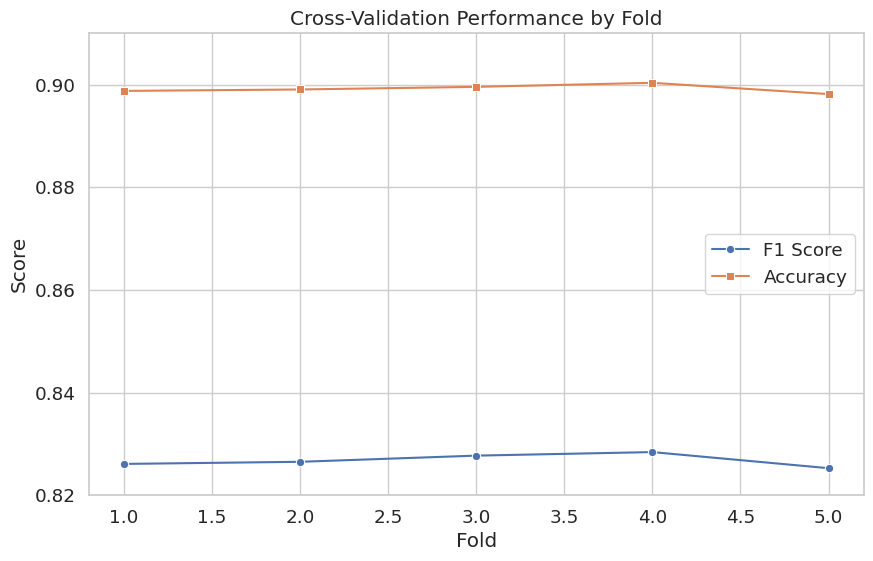

In [ ]:
#visualize by fold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert list of dicts to DataFrame
df = pd.DataFrame(all_fold_metrics)

# Plot F1 and Accuracy across folds
plt.figure(figsize=(10, 6))
sns.lineplot(x='fold', y='eval_f1', data=df, marker='o', label='F1 Score')
sns.lineplot(x='fold', y='eval_accuracy', data=df, marker='s', label='Accuracy')

plt.title('Cross-Validation Performance by Fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.ylim(0.82, 0.91)
plt.grid(True)
plt.legend()
plt.show()



Note: k-fold CV results validate that the model generalizes well and is not overfitting to any single fold.

#### Evaluate

In [ ]:
''' Save fine-tuned model '''
my_roberta_model = AutoModelForTokenClassification.from_pretrained(
    "/content/drive/MyDrive/cv/checkpoint-66795")

print("\Biomedical RoBERTa Model Config:")
print(my_roberta_model.config)

\Biomedical RoBERTa Model Config:
RobertaConfig {
  "architectures": [
    "RobertaForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PROBLEM",
    "2": "I-PROBLEM",
    "3": "E-PROBLEM",
    "4": "S-PROBLEM",
    "5": "B-TREATMENT",
    "6": "I-TREATMENT",
    "7": "E-TREATMENT",
    "8": "S-TREATMENT",
    "9": "B-TEST",
    "10": "I-TEST",
    "11": "E-TEST",
    "12": "S-TEST"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-PROBLEM": 1,
    "B-TEST": 9,
    "B-TREATMENT": 5,
    "E-PROBLEM": 3,
    "E-TEST": 11,
    "E-TREATMENT": 7,
    "I-PROBLEM": 2,
    "I-TEST": 10,
    "I-TREATMENT": 6,
    "O": 0,
    "S-PROBLEM": 4,
    "S-TEST": 12,
    "S-TREATMENT": 8
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type"

In [ ]:
# Recreate the trainer with best model
trainer_robert_test = Trainer(
    model=my_roberta_model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

#evaluate on test set
test_metrics = trainer_robert_test.evaluate(tokenized_ds["test"])
print(test_metrics)

/tmp/ipython-input-23-744072365.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_robert_test = Trainer(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cheryl-choo (cheryl-choo-asia-pacific-university-of-technology-innovation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.27089259028434753, 'eval_model_preparation_time': 0.0031, 'eval_accuracy': 0.9045070052292777, 'eval_f1': 0.8341940485419524, 'eval_runtime': 58.011, 'eval_samples_per_second': 767.596, 'eval_steps_per_second': 47.991}


In [ ]:
''' Save fine-tune model '''

#roberta_save_path = "/content/drive/MyDrive/cp2_robert_output/ft_roberta_humadex_ner"
roberta_save_path = "/data/ft_roberta_humadex_ner"

my_roberta_model.save_pretrained(roberta_save_path)

with open(os.path.join(roberta_save_path, "test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=4)

tokenizer.save_pretrained(roberta_save_path)

In [ ]:
from huggingface_hub import login, notebook_login, HfApi, create_repo, upload_folder

import dotenv
from dotenv import load_dotenv

load_dotenv()

login(token= os.getenv('HUGGINGFACE_TOKEN'))
api = HfApi()

MODEL_NAME = "ft-roberta-humadex-ner"

# Create repo if it doesn't exist yet
repo_url = api.create_repo(
    repo_id=f"{os.getenv('HF_USERNAME')}/{MODEL_NAME}",
    private=True
)

upload_folder(
    repo_id=f"{os.getenv('HF_USERNAME')}/{MODEL_NAME}",
    folder_path=roberta_save_path,
    path_in_repo="",  # root of repo
    commit_message="Upload fine-tuned Biomedical RoBERTa NER model"
)

print("Model pushed to Hub!")

Created repo at: https://huggingface.co/Fool-of-a-Took/ft-roberta-humadex-ner


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

✅ Model pushed to Hub!


### Try it out - Inference

Note:
RoBERTA sses Ġ (U+0120) to signal word boundaries.Tokens that start with Ġ are treated as new word starts.Tokens without Ġ are continuations of the previous word

Because RoBERTa does not use the conventional BERT-style subword (it uses Byte-Pair Encoding (BPE) tokenizer instead), so we need to change the subword logic to handle RoBERTa's Ġ.

In [ ]:
''' Load model and tokenizer from HuggingFace '''

from transformers import AutoTokenizer, AutoModelForTokenClassification

#to call
model = AutoModelForTokenClassification.from_pretrained("choo-c102/ft-roberta-humadex-ner")
tokenizer = AutoTokenizer.from_pretrained("choo-c102/ft-roberta-humadex-ner", add_prefix_space=True)

In [ ]:
#Function to decode entities

import torch

def decode_entities(tokens, labels):
    entities = []
    current_entity = []
    current_label = None

    for token, label in zip(tokens, labels):
        # Skip special tokens
        if token in tokenizer.all_special_tokens:
            continue

        # Remove symbol(Ġ)
        if token.startswith("Ġ"):
            token = token[1:]
            is_new_word = True
        else:
            is_new_word = False

        if label.startswith("B-"):
            # Save any previous entity
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
                current_entity = []

            current_entity = [token]
            current_label = label[2:]

        elif label.startswith("I-") or label.startswith("E-"):
            if is_new_word:
                # New word piece — still same entity
                current_entity.append(token)
            else:
                # Continuation of previous subword piece
                if current_entity:
                    current_entity[-1] += token
                else:
                    current_entity.append(token)

        elif label.startswith("S-"):
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
                current_entity = []
            entities.append((token, label[2:]))

        else:  # Label is 'O'
            if current_entity:
                entities.append((" ".join(current_entity), current_label))
                current_entity = []
                current_label = None

    if current_entity:
        entities.append((" ".join(current_entity), current_label))

    return entities

In [ ]:
#Test function with inference

inputs = tokenizer(
    "The patient has lower abdomen pain and nausea.",
    return_tensors="pt",
    truncation=True
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

outputs = my_roberta_model(**inputs)
logits = outputs.logits

predictions = torch.argmax(logits, dim=2)
pred_labels = predictions[0].cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
decoded_labels = [id2label[idx] for idx in pred_labels]

final_entities = decode_entities(tokens, decoded_labels)

print(final_entities)

[('lower abdomen pain', 'PROBLEM'), ('nausea', 'PROBLEM')]
